In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bell_Amundsen_Extent = pd.read_excel(filepath, sheet_name='Bell-Amundsen-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Bell_Amundsen_Extent)
fp.date_time(Bell_Amundsen_Extent)

,Extent,Date
0,1179855.894,1979-01-01
1,879585.254,1979-02-01
2,791619.096,1979-03-01
3,1254912.071,1979-04-01
4,1620142.247,1979-05-01
...,...,...
533,1556568.455,2023-06-01
534,1917507.979,2023-07-01
535,2601630.327,2023-08-01
536,2534223.780,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bell_Amundsen_Extent['Extent'] = scaler.fit_transform(Bell_Amundsen_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 6
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bell_Amundsen_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((521, 12, 1), (521,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bell_Amund_model_LT6/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 14s 163ms/step - loss: 0.2345 - root_mean_squared_error: 0.4842 - val_loss: 0.2096 - val_root_mean_squared_error: 0.4578
Epoch 2/50
53/53 [==============================] - 8s 144ms/step - loss: 0.1001 - root_mean_squared_error: 0.3164 - val_loss: 0.0667 - val_root_mean_squared_error: 0.2583
Epoch 3/50
53/53 [==============================] - 7s 130ms/step - loss: 0.0482 - root_mean_squared_error: 0.2196 - val_loss: 0.0666 - val_root_mean_squared_error: 0.2581
Epoch 4/50
53/53 [==============================] - 7s 141ms/step - loss: 0.0490 - root_mean_squared_error: 0.2213 - val_loss: 0.0625 - val_root_mean_squared_error: 0.2499
Epoch 5/50
53/53 [==============================] - 7s 143ms/step - loss: 0.0476 - root_mean_squared_error: 0.2182 - val_loss: 0.0622 - val_root_mean_squared_error: 0.2493
Epoch 6/50
53/53 [==============================] - 7s 133ms/step - loss: 0.0458 - root_mean_squared_error: 0.2141 - val_loss: 0.0593 - val

53/53 [==============================] - 1s 24ms/step - loss: 0.0151 - root_mean_squared_error: 0.1227 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1531
Epoch 28/50
53/53 [==============================] - 7s 137ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1503
Epoch 29/50
53/53 [==============================] - 7s 141ms/step - loss: 0.0146 - root_mean_squared_error: 0.1207 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1497
Epoch 30/50
53/53 [==============================] - 1s 27ms/step - loss: 0.0146 - root_mean_squared_error: 0.1206 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1536
Epoch 31/50
53/53 [==============================] - 1s 25ms/step - loss: 0.0150 - root_mean_squared_error: 0.1224 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1534
Epoch 32/50
53/53 [==============================] - 8s 145ms/step - loss: 0.0145 - root_mean_squared_error: 0.1202 - val_loss: 0.0220 - val_root_mean

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

5.1176303426424665 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

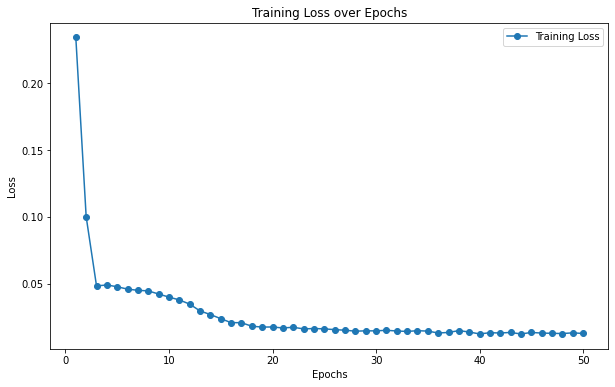

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

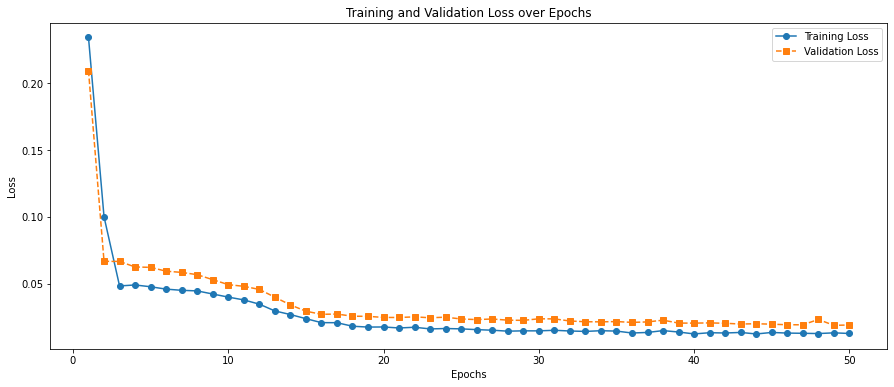

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bell_Amund_model_LT6/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 9ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.1126336823533533
MAE : 0.09397473374734108


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.881508e+06,1914289.680
1,1.498823e+06,1802244.842
2,1.153541e+06,1202791.069
3,8.712134e+05,752834.272
4,6.978906e+05,451914.219
5,6.194622e+05,439855.813
6,7.648111e+05,807857.307
7,1.121046e+06,1184280.145
8,1.533040e+06,1468308.405
9,1.778887e+06,1540851.607


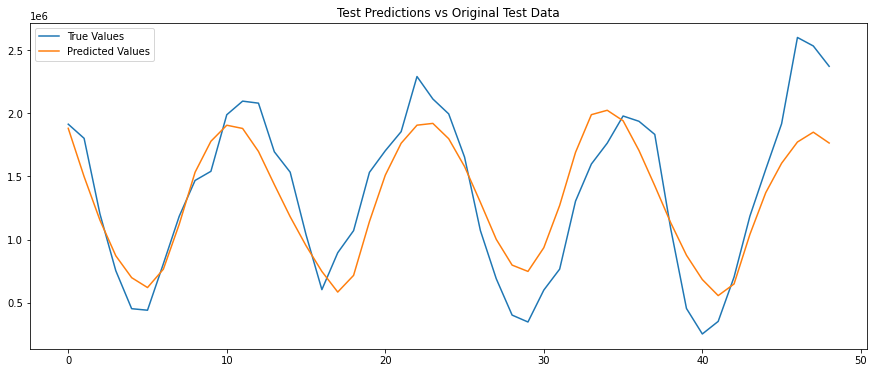

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 11ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

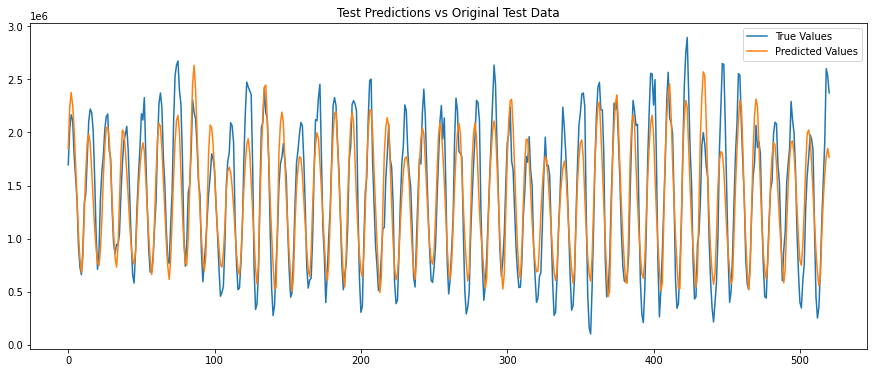

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()